# CS 429: Information Retrieval
<br>

## Lecture 12: Probabilistic IR, Part II

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology


Last time:

- Probabilistic justification for $idf$ weights

This time:

- Include term frequency
- Normalize by document length
  - BM25 (Okapi)
- Extensions to fielded search

# RSV (Retrieval Status Value)

$ RSV(d) = \sum_{i:x_i=q_i=1} \log \frac{N}{df_i}$ 

- sum of (log of) inverse document frequencies for each matching query term

**Assumptions of RSV:**

- a Boolean representation of documents/queries/relevance
- terms are conditionally independent given relevance
- terms not in the query don’t affect the outcome
- document relevance values are independent

# Multiplying by term frequency


$$ RSV_{tf}(d) = \sum_{i:x_i=q_i=1} \log \Big[ \frac{N}{df_i}\Big] \times tf_i$$


- but, want $tf$ scores to be bounded, so

$$ RSV_{tf}(d) = \sum_{i:x_i=q_i=1} \log \Big[ \frac{N}{df_i} \Big] \times \frac{(k+1)tf_i}{k + tf_i}$$

What is the effect of $k$?

Populating the interactive namespace from numpy and matplotlib


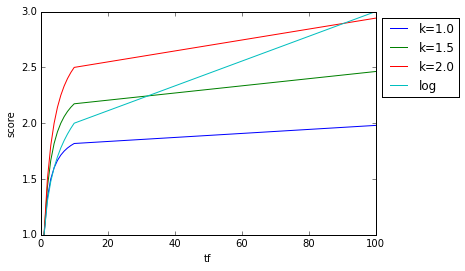

In [19]:
# Plot tf score as k varies.
import math

def tfscore(k, tf):
    return (k+1)*tf / (k+tf)

% pylab inline
ks = [1., 1.5, 2.0]
tfs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
for k in ks:
    plot(tfs, [tfscore(k, tf) for tf in tfs], label='k=' + str(k))
plot(tfs, [1 + math.log10(tf) for tf in tfs],label='log')
xlabel('tf')
ylabel('score')
legend(loc='upper left', bbox_to_anchor=(1,1))

larger $k \rightarrow $ slower "saturation" of score.

- like normal $tf$, but bounded in (1,2)

# Length normalization

Longer document $\rightarrow$ larger values of $tf_i$

- How can we level the playing field between long and short documents?
- Perhaps we should prefer longer documents?

# Document length

$l(d) = \sum_{i \in V} tf_i$

- Average document length

$\mu_l = \frac{1}{N}\sum_d l(d)$

Want to allow different levels of length normalization:

$$B = (1-b) + b \frac{l(d)}{\mu_l}$$

$$0 \le b \le 1$$

$0=$ no normalization
$1=$ full normalization

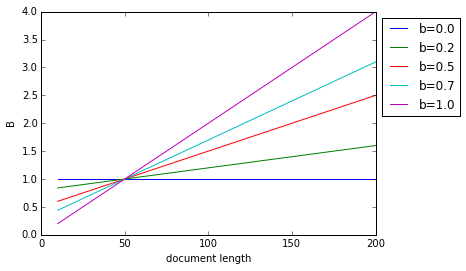

In [20]:
# What is the effect of b on the length normalization term B?
def len_norm(b, length, avg_length):
    return (1-b) + b * length / avg_length

bs = [0., 0.2, 0.5, 0.7, 1.]
lengths = [10, 30, 50, 100, 150, 200]
avg_length = 50
for b in bs:
    plot(lengths,
         [len_norm(b, length, avg_length) for length in lengths],
         label='b=' + str(b))
xlabel('document length')
ylabel('B')
legend(loc='upper left', bbox_to_anchor=(1,1))

- large $l(d) \rightarrow$ large $B$.
- large $b \rightarrow$ large $B$
- $l(d) < \mu_l$ $\rightarrow$  $0 < B < 1$
- $l(d) > \mu_l$ $\rightarrow$  $B > 1$ 

# To adjust $tf$ using $l(d)$:

$$tf_i' = \frac{tf_i}{B}$$

Replacing in RSV definition:

$$\begin{align}
BM25(d) & = & \sum_{i:x_i=q_i=1} \log \Big[\frac{N}{df_i}\Big] \times \frac{(k+1)tf_i'}{k + tf_i'}\\
& = & \sum_{i:x_i=q_i=1} \log \Big[ \frac{N}{df_i}\Big] \times \frac{(k+1)tf_i}{k((1-b) + b \frac{l(d)}{\mu_l}) + tf_i}\\
& = & \sum_{i:x_i=q_i=1} \log \Big[\frac{N}{df_i}\Big] \times \frac{(k+1)tf_i}{Bk + tf_i}
\end{align}$$

**BM25:** "Best Match" 25 system (aka "[Okapi](http://en.wikipedia.org/wiki/Okapi_BM25)")

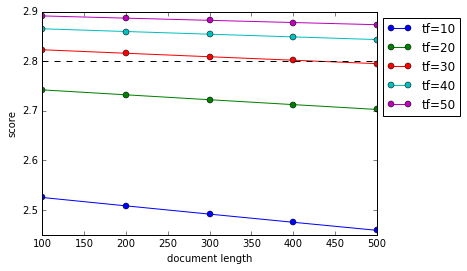

In [7]:
# How does score vary with tf and document length?
%matplotlib inline
import matplotlib.pyplot as plt
def score(k, b, tf, length, m_length):
    return (k + 1) * tf / (k * ((1 - b) + b * length / m_length) + tf)
    
tfs = [10, 20, 30, 40, 50]
lengths = [100, 200, 300, 400, 500]
m_length = 250
k = 2.  # tf strength
b = .1  # length normalization strength. E.g., try .1, .5, 1

for tf in tfs:
    plt.plot(lengths,
        [score(k, b, tf, length, m_length) for length in lengths],
        'o-', label='tf=' + str(tf))
plt.plot(lengths, [2.8] * len(lengths), 'k--')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('document length')
plt.ylabel('score')

Compare: 

- two documents with same tf but different lengths
- two documents with same length but different tf

# Fielded search

How can we combine scores from multiple fields? (title, author, etc.)

**Simple way:** Score each field separately and take the average.

- Assumes each field the same

Instead, take weighted average:

$tf^F_i = \sum_{z=1}^Z v_z tf_{zi}$

$l^F(d) = \sum_{z=1}^Z v_z l(d_z)$

$\mu^F_l = \frac{1}{N} \sum_d l^F(d)$

- $Z$: number of fields
- $tf_{zi}$: $tf$ of term $i$ in field $z$
- $l(d_z)$: length of field $z$
- $v_z$: weight for field $z$





$ \begin{align}
BM25F(d) = \sum_{i:x_i=q_i=1} \log \Big[\frac{N}{df_i}\Big] \times \frac{(k+1)tf^F_i}{k((1-b) + b \frac{l^F(d)}{\mu^F_l}) + tf^F_i}
\end{align}
$

Could also have different $b$ for each field. Why?

# Exercise

There are four documents in the world, with the following term frequencies:

- $d_1: $ {dog: 4, cat: 6, the: 10}
- $d_2: $ {dog: 2, the: 8}
- $d_3: $ {zebra: 20}
- $d_4: $ {zebra: 30}

Consider the query **(the dog)**. Let $b=1$ and $k=2$. Fill in the values in this table (showing your work):

<table>
  <tr> <td> </td> <td>RSV</td> <td>BM25</td></tr>
  <tr> <td> $d_1$ </td> <td> </td> <td> </td></tr>
  <tr> <td> $d_2$ </td> <td> </td> <td> </td></tr>
</table>

$$ \begin{align}
BM25(d) & = & \sum_{i:x_i=q_i=1} \log \Big[ \frac{N}{df_i}\Big] \times \frac{(k+1)tf_i}{k((1-b) + b \frac{l(d)}{\mu_l}) + tf_i}\\
\end{align}
$$

$$ \begin{align}
RSV(d) & = & \sum_{i:x_i=q_i=1} \log \frac{N}{df_i}
\end{align}
$$